## Домашнее здание №2 / Link Prediction

### Саутин Андрей / 396

----
План выполнения домашнего задания:

1. Краткий обзор исходных данных
2. Генерация дополнительных данных
3. Создание матрицы признаков для ребер
4. Настройка модели и валидация качества модели
5. Отправка результатов в контест на Kaggle

----

В данном домашнем задании вам предстоит построить классификатор, который бы предсказывал наличие или отсутствия ребра в графе между двумя вершинами. Никакой дополнительной информации о вершинах, кроме ее соседей нет, поэтому вам придется создавать вектор признаков для каждой пары вершин на основе топологии графа.

Вершины графа - товары интернет магазина, наличие ребра символизируют о высокой частоте совместной покупки данных товаров вместе. Например если в нашем графе присутствую вершины молоко и хлеб и данные товары часто покупаются вместе, то между данными вершинами будет ребро. Если в нашем графе есть вершины молоко и кроссовки, то между данными вершинами ребра не будет. 

В данном датасете уровень относительной частоты по которому решается есть ребро между вершинами или его нет был определен за нас. Сам датасет был получен краулингом сайта Amazon.com в марте 2003 года, парсилась секция "Люди которые купили данный продукт, также преобретали это..."

Мотивация данного задания: Расширить список блока рекомендаций, за счет товаров которые с высокой вероятность могут оказаться в одной корзине покупателя.

----
Для создания модели и работы с данными мы будем использовать пакет GraphLab, структуры данных SFrame и SGraph идеально подходят для работы с графами. Распределенное хранение данных и применения функций для расчета метрик отдельных вершин сильно облегчают работу с графом.

Библиотека платная, но лицензия для академических целей получается в течении 5 минут, чтобы установить пакет следуйте шагам на сайте - https://turi.com/download/academic.html

----

Описание файлов:

1. the_graph.csv - файл содержащий ребра графа, две колонки: src,dst 
2. suspicions.csv - файл с ребрами, графа. Для данных ребер неизвестно присутствует ли оно в графе или нет.

Описание целевой метрики - в качестве целевой метрики будем использовать ROC AUC http://mlwiki.org/index.php/ROC_Analysis

----

In [1]:
import graphlab as gl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

gl.canvas.set_target('ipynb')

This non-commercial license of GraphLab Create for academic use is assigned to sautin@phystech.edu and will expire on November 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479241806.log


### 1. Краткий обзор исходных данных - 10 Баллов

Загрузим данные, найдем ряд базовых статистик:

1. Количество вершин и ребер
2. Распределение степеней вершин графа (График log - log)
3. Плотность графа
4. Диаметр графа
5. Количество треугольников в графе
6. Краткие выводы о данных.
7. БОНУСЫ - сделайте красивую визулизацию или расчет дополнительных метрик с выводами и вы получите дополнительные баллы за задание

In [2]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)

In [3]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

#### 1.1. Количество вершин и ребер

In [4]:
vert_edgs = g.summary()
vert_count = vert_edgs['num_vertices']
edge_count = vert_edgs['num_edges']

print 'Number of vertices = {0}'.format(vert_count)
print 'Number of edges = {0}'.format(edge_count)

Number of vertices = 262111
Number of edges = 1384871


Выполните пункты 2 - 6. В пункте 6 напишите краткие выводы.

#### 1.2. Распределение степеней вершин графа (График log - log)

In [5]:
# count degrees
deg = gl.degree_counting.create(g)
deg_graph = deg['graph']
degrees_in = deg_graph.vertices[['__id', 'in_degree']]
degrees_out = deg_graph.vertices[['__id', 'out_degree']]
degrees_total = deg_graph.vertices[['__id', 'total_degree']]
degrees_total_val = degrees_total['total_degree']
print degrees_total.head()

+------+--------------+
| __id | total_degree |
+------+--------------+
|  5   |      59      |
|  7   |      40      |
|  8   |     300      |
|  10  |      41      |
|  27  |      46      |
|  29  |      47      |
|  33  |     367      |
|  47  |      10      |
|  50  |      11      |
|  52  |      20      |
+------+--------------+
[10 rows x 2 columns]



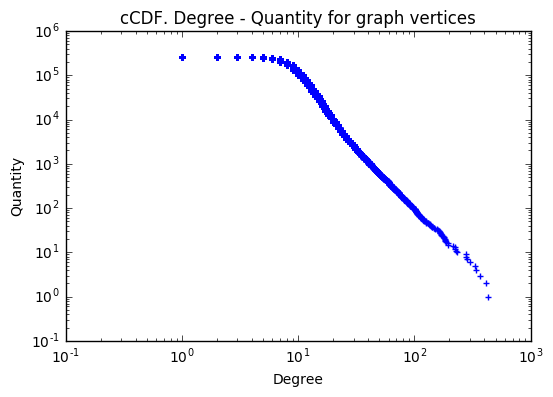

In [6]:
degrees = np.array(sorted(degrees_total_val, reverse=True))
plt.xscale('log'), plt.yscale('log')
plt.scatter(degrees, 1 + np.arange(degrees.shape[0]), 
            label = 'cCDF', c = 'blue', marker = '+')
plt.title('cCDF. Degree - Quantity for graph vertices')
plt.xlabel('Degree'), plt.ylabel('Quantity')
plt.show()

In [7]:
## prepare data for plotting
# degrees_total_val = degrees_total['total_degree']
# hist, bin_edges = np.histogram(degrees_total_val, bins='auto', density=False)
# hist = hist / float(np.sum(hist))
# hist_sum = np.cumsum(hist)
# print hist_sum.shape
# print bin_edges.shape

# plt.xscale('log'), plt.yscale('log')
# plt.title('Graph Vertices Total Degree CDF & PDF')
# plt.xlabel('x')
# plt.plot(bin_edges[:-1], hist, label='PDF, probability P(x)')
# plt.plot(bin_edges[:-1], hist_sum, label='CDF, probability (degree <= x)')
# plt.legend(fontsize='x-small')
# plt.show()

#### 1.3. Плотность графа

In [8]:
graph_density = 2 * float(edge_count) / (vert_count * (vert_count - 1))
print 'Graph density: {}'.format(graph_density)

Graph density: 4.03153541186e-05


#### 1.4. Диаметр графа

In [9]:
%%time
graph_diam = 0

for i in xrange(vert_count):
    sp = gl.shortest_path.create(g, source_vid=i, verbose=False)
    sp_sframe = sp['distance']['distance']
    graph_diam = max(sp_sframe.max(), graph_diam)
    if graph_diam > vert_count - 1:
        break

print 'Graph diameter = {}'.format(graph_diam if graph_diam <= vert_count - 1 else 'INF')

Graph diameter = INF
CPU times: user 1min 7s, sys: 708 ms, total: 1min 8s
Wall time: 29.3 s


#### 1.5. Количество треугольников в графе

In [10]:
tc = gl.triangle_counting.create(g)
triangle_count = tc['num_triangles']
print 'Triangle count = {}'.format(triangle_count)

Initializing vertex ids.

Removing duplicate (bidirectional) edges.

Counting triangles...

Finished in 9.98595 secs.

Total triangles in the graph : 717754

Triangle count = 717754


#### 1.6. Краткие выводы о данных

Ребер всего в ~5 раз больше, чем вершин, что при таких размерностях говорит о том, что граф скорее можно назвать разреженным нежели полным. Это подтверждается и наличием пар недостижимых вершин, а также очень низкой плотностью графа. 
Кроме того в графе присутствует большое количество треугольников, что говорит о наличии преимущественно близких связей ("правило 6-ти рукопожатий"). Эта же идея находит отражение и в том факте, что распределение степеней вершин близко к экспоненциальному.  

В итоге, имеем достаточно большую, но разреженную сеть с недостижимыми вершинами и наличием подграфов, плотность внутри которых сильно выше плотности по всему графу.

#### 1.7. Направленность ребер (дополнительно)

In [11]:
# check directed/undirected
edges_undir = zip(edges['src'], edges['dst']) + zip(edges['dst'], edges['src'])
directed = len(set(edges_undir)) < len(edges_undir)
print 'Graph is {}'.format('directed' if directed else 'undirected')

Graph is directed


#### 1.8. Количество компонент слабой связности (дополнительно)

In [12]:
cc = gl.connected_components.create(g, verbose=0)
cc_ids = cc['component_id']
print 'Number of weak components: {}'.format(cc_ids['component_id'].max())

Number of weak components: 6


Несмотря на малое количество ребер в графе, выделяются всего 6 компонент слабой связности, что говорит о тесной связи между продуктами, представленными в виде вершин графа.

----
### 2. Генерация дополнительных данных - 20 Баллов

Перед нами стоит задача создания модели классификации, которая в дальнейшем будет использоваться для повышения разнообразия блока рекомендаций. Для большинства моделей классификации требуется минимум 2 класса объектов - негативный и позитивный. Но у нас есть только граф, ребра которые в нем присутствуют это позитивные примеры. Получается, что у нас нет негативных примеров. 

Ответьте на 3 вопроса:

1. Можем ли мы сами создать негативные примеры? Граф это описание связей между вершинами, если мы будем случайным образом выбирать две вершины и считать, что это ребро - негативный пример, имеет ли это смысл?
2. Если мы решим сгенерировать негативные примеры, как должна быть устроена процедура генерации, чтобы обобщаяющая способность модели была наилучшей?
3. Как зависит обобщающая способность модели от негативных примеров, которые мы ей покажем?

__Ответы:__
1. Мы можем сами создать негативные примеры, однако результат классификации будет напрямую зависеть от определенного нами способа их выбора. Ведь если ребро отсутствует между двумя вершинами в исходном графе, то возможны два случая:  
    * ребра действительно нет;
    * ребро есть, но нам не было об этом сказано (т.е. ожидается, что мы предскажем наличие этого ребра).  
   
    В связи с этим абсолютно бессмысленно генерировать негативные примеры, выбирая две случайных вершины и проверяя наличие ребра между ними в исходном графе. 
    
    Если подразумевалось, что все ребра, не встречающиеся в тестовой выборке и в исходном графе гарантированно отсутствуют, то все эти рассуждения не имеют большого смысла. В таком случае для генерации негативных примеров достаточно взять все ребра из дополнения данного графа и удалить из этого множества те, что встречаются в тесте.

2. Хотелось бы устроить генерацию так, чтобы с высокой вероятностью не считать негативными примерами те ребра, которые на самом деле существуют. Например, можно рассчитать наименьшее расстояние между всеми вершинами и считать негативными примерами те пары вершин, кратчайшее расстояние между которыми превышает какую-то константу. В нашей предметной области это будет значить, что товары вряд ли сильно связаны по своей сути и скорее всего относятся к разным категориям товаров. Таким образом, мы используем некоторые известные нам характеристики графа, а также учитываем природу его возникновения.

3. Чтобы поддержать обобщающую способность модели необходимо генерировать негативные примеры, минимально опираясь на структуру конкретно этого графа и используя наиболее общие для всех подобных графов статистики.

Также для повышения результата логично исключить из негативных примеров ребра, которые присутствуют в тесте.

------
Создадим класс отрицательных примеров, сгенерировав его самым простым образом: берем две вершины, если ребро между ними отсутствует в графе, то это отрицательный пример.

1. Попробуйте улучшить генерацию отрицательных примеров

In [13]:
# read in existing edges
graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)

1384871


In [14]:
# read test edges
test_edges = set()
with open('suspicions.csv') as test_file:
    test_file.readline() # first line is column names
    for line in test_file:
        _, start, end = map(int, line.split(','))
        test_edges.add((start, end))

print len(test_edges)

299994


In [15]:
# generating negative examples, so that class balance is 50/50 
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])
    
    if (start != end) and ((start, end) not in existing_edges):
        generated_nonexisting_edges.append([start, end, 0])
        
    counter += 1
    if counter == vert_edgs['num_edges']:
        break

print len(generated_nonexisting_edges)

1384832


In [16]:
# # generating negative examples using distances
# # is very time-consuming, therefore I used stupidly generated negative examples + filtered those that are in test

# DIST_MAX_HAS_EDGE = 5

# generated_nonexisting_edges = []
# for counter in xrange(vert_edgs['num_edges']):
#     while True:
#         start = np.random.randint(0, vert_edgs['num_vertices'])
#         end = np.random.randint(0, vert_edgs['num_vertices'])
#         sp = gl.shortest_path.create(g, source_vid=start, verbose=False)
#         sp_sframe = sp['distance']
#         sp_sframe = sp_sframe[sp_sframe['__id'] == end]
#         sp_sframe.materialize()
#         dist = sp_sframe['distance'][0]

#         if (start != end) and ((start, end) not in existing_edges) and (dist > DIST_MAX_HAS_EDGE):
#             generated_nonexisting_edges.append([start, end, 0])
# #             print 'added ', start, ' -> ', end
#             break

# print len(generated_nonexisting_edges)

In [17]:
%%time
# generating negative examples

generated_nonexisting_edges = []
for counter in xrange(vert_edgs['num_edges']):
    while True:
        start = np.random.randint(0, vert_edgs['num_vertices'])
        end = np.random.randint(0, vert_edgs['num_vertices'])

        if (start != end) and ((start, end) not in existing_edges) and ((start, end) not in test_edges):
            generated_nonexisting_edges.append([start, end, 0])
#             print 'added ', start, ' -> ', end
            break

print len(generated_nonexisting_edges)

1384871
CPU times: user 16.3 s, sys: 116 ms, total: 16.4 s
Wall time: 16.4 s


In [18]:
# create SFrame with negative examples
generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges, columns=['src', 'dst', 'class'])
generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges)

In [19]:
# add target function to the original dataset 
edges['class'] = [1]*edges.shape[0]

In [20]:
# add negative examples to the main data and shuffle
edges = edges.append(generated_nonexisting_edges)
edges = gl.cross_validation.shuffle(edges)

In [21]:
# update our graph g with fake edges
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

In [22]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 2769742


In [23]:
print edges[:5]

+--------+--------+-------+
|  src   |  dst   | class |
+--------+--------+-------+
| 108328 | 57592  |   1   |
| 210251 | 215436 |   1   |
| 95770  | 141433 |   0   |
|  636   | 12365  |   0   |
| 153639 | 40560  |   0   |
+--------+--------+-------+
[5 rows x 3 columns]



----
### 3. Создание матрицы признаков для ребер - 30 Баллов

Для создания модели классификации нам необходимы признаки, которые описывают каждое ребро. Вот базовый список того, что можно посчитать:

Для вершин:

1. Список и количество вершин, из которых ребра приходят в данную вершину
2. Список и количество вершин, в которые ребра приходят из данной вершины
3. Список и количество вершин связанных с данной вершиной
4. Список и количество вершин, которые связанны с данной вершиной как входящими, так и исходящими ребрами

Также можно добавить: вершины с которыми данная вершина образует треугольники, кластеризовать вершины и использовать кластер данной вершины и др.

Придумайте дополнительные интересные признаки для вершин и вы получите дополнительный балл за домашнюю работу!

In [24]:
all_vertices = g.get_vertices()
all_vertices.rename({"__id": "id"}) 
all_vertices.head(5)

id
5
7
8
10
27


In [25]:
# calculating each vertices in and out connections
out_vertices = edges.groupby("src", {"out_vertices": gl.aggregate.CONCAT("dst")})
out_vertices.rename({"src": "id"})

in_vertices = edges.groupby("dst", {"in_vertices": gl.aggregate.CONCAT("src")})
in_vertices.rename({"dst": "id"})
print out_vertices[:5]

+--------+-------------------------------+
|   id   |          out_vertices         |
+--------+-------------------------------+
| 251434 | [250137, 56222, 115886, 25... |
| 211023 | [232183, 202342, 181032, 1... |
| 21855  | [104905, 15075, 25114, 251... |
| 233270 | [258684, 139583, 200836, 1... |
| 88004  | [244635, 64573, 72281, 880... |
+--------+-------------------------------+
[5 rows x 2 columns]



In [26]:
# join in and out connections with all_vertices
all_vertices = all_vertices.join(out_vertices, on="id", how="outer")
all_vertices = all_vertices.join(in_vertices, on="id", how="outer")

# replace missing values with empty lists
all_vertices = all_vertices.fillna('in_vertices',[])
all_vertices = all_vertices.fillna('out_vertices',[])
all_vertices.head(3)

id,out_vertices,in_vertices
251434,"[250137, 56222, 115886,255120, 4126, 240147, ...","[146977, 53134, 204624,149617, 13675, 250137, ..."
211023,"[232183, 202342, 181032,198886, 129442, 159269, ...","[236267, 109374, 130553,248527, 233626, 198886, ..."
21855,"[104905, 15075, 25114,25115, 21854, 184729, ...","[162607, 37428, 191808,49405, 64737, 126985, ..."


In [27]:
# add in-and-out and in-or-out connections

all_vertices['in_and_out_vertices'] = all_vertices[['in_vertices', 'out_vertices']].apply(
    lambda row: list(set(row['in_vertices']) & set(row['out_vertices']))
)
all_vertices['in_or_out_vertices'] = all_vertices[['in_vertices', 'out_vertices']].apply(
    lambda row: list(set(row['in_vertices']) | set(row['out_vertices']))
)

all_vertices['in_and_out_vertices'] = all_vertices['in_and_out_vertices'].astype(list)
all_vertices['in_or_out_vertices'] = all_vertices['in_or_out_vertices'].astype(list)

all_vertices = all_vertices.fillna('in_and_out_vertices', [])
all_vertices = all_vertices.fillna('in_or_out_vertices', [])
all_vertices.head(3)

id,out_vertices,in_vertices,in_and_out_vertices,in_or_out_vertices
251434,"[250137, 56222, 115886,255120, 4126, 240147, ...","[146977, 53134, 204624,149617, 13675, 250137, ...","[250137.0, 255119.0]","[146977.0, 166244.0,240872.0, 255120.0, ..."
211023,"[232183, 202342, 181032,198886, 129442, 159269, ...","[236267, 109374, 130553,248527, 233626, 198886, ...","[233626.0, 198886.0]","[248527.0, 124113.0,189714.0, 208410.0, ..."
21855,"[104905, 15075, 25114,25115, 21854, 184729, ...","[162607, 37428, 191808,49405, 64737, 126985, ...","[15075.0, 25116.0,21854.0] ...","[191808.0, 64737.0,104905.0, 15075.0, ..."


Мы получили базовый набор данных - список входящих и исходящих вершин, для каждой вершины. Теперь найдем количества вершин для метрик 1 и 2. Метрики 3 и 4 вы посчитаете сами

In [28]:
# in_degree - number of users following each vertex
all_vertices['in_degree'] = all_vertices["in_vertices"].apply(lambda x: len(x) )

all_vertices['in_and_out_degree'] = all_vertices['in_and_out_vertices'].apply(lambda x: len(x))
all_vertices['in_or_out_degree'] = all_vertices['in_or_out_vertices'].apply(lambda x: len(x))

# out_degree - number of users each vertex is following
all_vertices['out_degree'] = all_vertices["out_vertices"].apply(lambda x: len(x) )

In [29]:
all_vertices.head(3)

Columns:
	id	int
	out_vertices	list
	in_vertices	list
	in_and_out_vertices	list
	in_or_out_vertices	list
	in_degree	int
	in_and_out_degree	int
	in_or_out_degree	int
	out_degree	int

Rows: 3

Data:
+--------+-------------------------------+-------------------------------+
|   id   |          out_vertices         |          in_vertices          |
+--------+-------------------------------+-------------------------------+
| 251434 | [250137, 56222, 115886, 25... | [146977, 53134, 204624, 14... |
| 211023 | [232183, 202342, 181032, 1... | [236267, 109374, 130553, 2... |
| 21855  | [104905, 15075, 25114, 251... | [162607, 37428, 191808, 49... |
+--------+-------------------------------+-------------------------------+
+-----------------------------+-------------------------------+-----------+-------------------+
|     in_and_out_vertices     |       in_or_out_vertices      | in_degree | in_and_out_degree |
+-----------------------------+-------------------------------+-----------+-------------------+
|     [250137.0, 255119.0]    | [146977.0, 166244.0, 24087... |     10    |         2         |
|     [233626.0, 198886.0]    | [248527.0, 124113.0, 18971... |     12    |         2         |
| [15075.0, 25116.0, 21854.0] | [191808.0, 64737.0, 104905... |     13    |         3         |
+-----------------------------+-------------------------------+-----------+-------------------+
+------------------+------------+
| in_or_out_degree | out_degree |
+------------------+------------+
|        17        |     9      |
|        22        |     12     |
|        18        |     8      |
+------------------+------------+
[3 rows x 9 columns]

Мы получили характеристики для каждой вершины графа. Так как у нас задача предсказания наличия ребра, мы должны составить описание каждого ребра, используя метрики вершин. После составления характеристик ребер, мы можем перейти к генерации свойств ребер, взяв за основу метрики вершин ребра. Пример метрик для ребер, которые мы можем найти:

1. Общие друзья вершин ребра
2. Общее количество друзей вершин ребра
3. Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

Данные метрики находятся для каждого списка вершин, пунктов 1 - 4

In [30]:
all_vertices

id,out_vertices,in_vertices,in_and_out_vertices
251434,"[250137, 56222, 115886,255120, 4126, 240147, ...","[146977, 53134, 204624,149617, 13675, 250137, ...","[250137.0, 255119.0]"
211023,"[232183, 202342, 181032,198886, 129442, 159269, ...","[236267, 109374, 130553,248527, 233626, 198886, ...","[233626.0, 198886.0]"
21855,"[104905, 15075, 25114,25115, 21854, 184729, ...","[162607, 37428, 191808,49405, 64737, 126985, ...","[15075.0, 25116.0,21854.0] ..."
233270,"[258684, 139583, 200836,161558, 144450, 155998, ...","[175862, 137936, 229329,135662, 39368, 228296] ...",[229329.0]
88004,"[244635, 64573, 72281,88002, 128647, 193701, ...","[255591, 96497, 125651,88003, 88005, 130339, ...","[72281.0, 88002.0,88003.0, 88005.0] ..."
79732,"[49437, 79730, 75040,81407, 188417, 255344, ...","[81407, 83186, 26725,198512, 81408, 134130, ...","[75040.0, 83186.0,79730.0, 79734.0, ..."
63664,"[58327, 110648, 218347,72586, 210024, 80726, ...","[116067, 80915, 110648,53209, 151381, 80726, ...","[110648.0, 116067.0,46916.0, 80726.0] ..."
127950,"[21468, 98108, 198150,127952, 28500, 36117, ...","[191876, 127952, 98108,84284, 48454, 190588] ...","[127952.0, 98108.0]"
7899,"[22880, 243752, 27312,8977, 67627, 11624, ...","[8977, 6150, 142873,27312, 168840, 15258, ...","[27312.0, 8977.0, 7896.0]"
25263,"[125673, 6961, 99749,42350, 6965, 42349, ...","[6965, 155804, 174885,91014, 111709, 42349, ...","[42349.0, 6965.0]"


In [31]:
edges = edges.join(all_vertices, on={"src": "id"}, how="right")
edges.rename({"in_vertices": "src_in_vertices", "out_vertices": "src_out_vertices",
                  "in_degree": "src_in_degree", "out_degree": "src_out_degree"
                 })

edges = edges.join(all_vertices, on={"dst": "id"}, how="right")
edges.rename({"in_vertices": "dst_in_vertices", "out_vertices": "dst_out_vertices",
                  "in_degree": "dst_in_degree", "out_degree": "dst_out_degree"})

edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	in_and_out_vertices	list
	in_or_out_vertices	list
	src_in_degree	int
	in_and_out_degree	int
	in_or_out_degree	int
	src_out_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	in_and_out_vertices.1	list
	in_or_out_vertices.1	list
	dst_in_degree	int
	in_and_out_degree.1	int
	in_or_out_degree.1	int
	dst_out_degree	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 108328 | 57592  |   1   | [57592, 58801, 57593, 6370... |
| 210251 | 215436 |   1   | [215436, 194070, 163168, 2... |
| 95770  | 141433 |   0   | [141433, 186015, 26289, 21... |
+--------+--------+-------+-------------------------------+
+-------------------------------+----------------------+
|        src_in_vertices        | in_and_out_vertices  |
+-------------------------------+----------------------+
| [57594, 148635, 153284, 12... | [57594.0, 129909.0]  |
| [162601, 184555, 102481, 2... | [215435.0, 215436.0] |
| [50883, 140990, 231776, 25... |      [95517.0]       |
+-------------------------------+----------------------+
+-------------------------------+---------------+-------------------+------------------+
|       in_or_out_vertices      | src_in_degree | in_and_out_degree | in_or_out_degree |
+-------------------------------+---------------+-------------------+------------------+
| [153284.0, 106632.0, 12039... |       12      |         2         |        21        |
| [258049.0, 29315.0, 2249.0... |       13      |         2         |        22        |
| [33376.0, 50883.0, 63553.0... |       7       |         1         |        18        |
+-------------------------------+---------------+-------------------+------------------+
+----------------+-------------------------------+
| src_out_degree |        dst_out_vertices       |
+----------------+-------------------------------+
|       11       | [78574, 218918, 57406, 785... |
|       11       | [194309, 87925, 130566, 68... |
|       12       | [164628, 118224, 32111, 99... |
+----------------+-------------------------------+
+--------------------------------+-------------------------------+
|        dst_in_vertices         |     in_and_out_vertices.1     |
+--------------------------------+-------------------------------+
| [108328, 57594, 72403, 785...  | [57594.0, 57406.0, 78574.0... |
| [210251, 215435, 8854, 102120] |      [210251.0, 215435.0]     |
| [95770, 118224, 158342, 79...  |      [118224.0, 158342.0]     |
+--------------------------------+-------------------------------+
+-------------------------------+---------------+---------------------+--------------------+
|      in_or_out_vertices.1     | dst_in_degree | in_and_out_degree.1 | in_or_out_degree.1 |
+-------------------------------+---------------+---------------------+--------------------+
| [230530.0, 182085.0, 14721... |       18      |          4          |         22         |
| [215435.0, 194309.0, 13056... |       4       |          2          |         14         |
| [6080.0, 158342.0, 84104.0... |       13      |          2          |         24         |
+-------------------------------+---------------+---------------------+--------------------+
+----------------+
| dst_out_degree |
+----------------+
|       8        |
|       12       |
|       13       |
+----------------+
[3 rows x 19 columns]

#### Общие друзья для списков вершин

Найдем пункт 1 - общих друзей для списков вершин из пункта 1. Пункты 2 и 3 вы посчитаете самостоятельно

In [32]:
def common_friends(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return len(u_neighbors & v_neighbors)

In [33]:
edges['common_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'], x['src_in_vertices'], x['dst_in_vertices'])))

In [34]:
edges[:3]

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	in_and_out_vertices	list
	in_or_out_vertices	list
	src_in_degree	int
	in_and_out_degree	int
	in_or_out_degree	int
	src_out_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	in_and_out_vertices.1	list
	in_or_out_vertices.1	list
	dst_in_degree	int
	in_and_out_degree.1	int
	in_or_out_degree.1	int
	dst_out_degree	int
	common_in_vertices	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 108328 | 57592  |   1   | [57592, 58801, 57593, 6370... |
| 210251 | 215436 |   1   | [215436, 194070, 163168, 2... |
| 95770  | 141433 |   0   | [141433, 186015, 26289, 21... |
+--------+--------+-------+-------------------------------+
+-------------------------------+----------------------+
|        src_in_vertices        | in_and_out_vertices  |
+-------------------------------+----------------------+
| [57594, 148635, 153284, 12... | [57594.0, 129909.0]  |
| [162601, 184555, 102481, 2... | [215435.0, 215436.0] |
| [50883, 140990, 231776, 25... |      [95517.0]       |
+-------------------------------+----------------------+
+-------------------------------+---------------+-------------------+------------------+
|       in_or_out_vertices      | src_in_degree | in_and_out_degree | in_or_out_degree |
+-------------------------------+---------------+-------------------+------------------+
| [153284.0, 106632.0, 12039... |       12      |         2         |        21        |
| [258049.0, 29315.0, 2249.0... |       13      |         2         |        22        |
| [33376.0, 50883.0, 63553.0... |       7       |         1         |        18        |
+-------------------------------+---------------+-------------------+------------------+
+----------------+-------------------------------+
| src_out_degree |        dst_out_vertices       |
+----------------+-------------------------------+
|       11       | [78574, 218918, 57406, 785... |
|       11       | [194309, 87925, 130566, 68... |
|       12       | [164628, 118224, 32111, 99... |
+----------------+-------------------------------+
+--------------------------------+-------------------------------+
|        dst_in_vertices         |     in_and_out_vertices.1     |
+--------------------------------+-------------------------------+
| [108328, 57594, 72403, 785...  | [57594.0, 57406.0, 78574.0... |
| [210251, 215435, 8854, 102120] |      [210251.0, 215435.0]     |
| [95770, 118224, 158342, 79...  |      [118224.0, 158342.0]     |
+--------------------------------+-------------------------------+
+-------------------------------+---------------+---------------------+--------------------+
|      in_or_out_vertices.1     | dst_in_degree | in_and_out_degree.1 | in_or_out_degree.1 |
+-------------------------------+---------------+---------------------+--------------------+
| [230530.0, 182085.0, 14721... |       18      |          4          |         22         |
| [215435.0, 194309.0, 13056... |       4       |          2          |         14         |
| [6080.0, 158342.0, 84104.0... |       13      |          2          |         24         |
+-------------------------------+---------------+---------------------+--------------------+
+----------------+--------------------+
| dst_out_degree | common_in_vertices |
+----------------+--------------------+
|       8        |         1          |
|       12       |         1          |
|       13       |         0          |
+----------------+--------------------+
[3 rows x 20 columns]

Результатом пункта 3 является матрица признаков. Теперь мы готовы занятся настройкой моделей. Главная ваша задача в пункте 3 - подготовить как можно больше качественных признаков, которые могли бы использоваться для настройки модели машинного обучения.

----
### 4. Настройка модели и валидация качества модели - 20 Баллов

Исключим подозрительные ребра из рассмотрения, а затем разобьем датасет на 2 части, для обучения и проверки результатов. Настроим базовую модель классификации - логистическую регрессию.
Для улучшения качества модели вам предстоит выполнить следующие пункты:

1. Кросс - валидация для настройки гиперпараметров модели и регуляризации
2. Подбор модели машинного обучения (случайный лес, бустинг, нейронная сеть и т.д.)

In [22]:
susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
print susp.shape

(299994, 3)


In [23]:
print edges.shape
edges = edges.join(susp, on=['src', 'dst'], how='left')
print edges.shape

(2769712, 12)
(2769712, 13)


In [24]:
clean_edges = edges[edges['edge_id'] == None]
susp_edges = edges[edges['edge_id'] != None]
print clean_edges.shape, susp_edges.shape

(2469718, 13) (299994, 13)


In [25]:
clean_edges.remove_column('edge_id')
print

In [26]:
clean_edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_degree	int
	src_out_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_degree	int
	dst_out_degree	int
	common_in_vertices	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 101355 | 48945  |   0   | [48945, 144461, 212543, 88... |
| 46194  | 185867 |   0   | [185867, 75042, 46193, 184... |
| 224536 | 206071 |   1   | [206071, 218520, 161, 1624... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+
|        src_in_vertices        | src_in_degree | src_out_degree |
+-------------------------------+---------------+----------------+
| [28229, 20714, 88679, 3372... |       5       |       12       |
| [31625, 191284, 73421, 108... |       13      |       7        |
| [206071, 189583, 226504, 2... |       8       |       12       |
+-------------------------------+---------------+----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [17610, 212149, 35485, 210... | [101355, 54363, 173623, 20... |       12      |
| [43157, 207398, 104024, 12... | [46194, 117192, 189506, 15... |       8       |
| [215731, 224536, 174005, 1... | [224536, 224537, 164200, 5... |       7       |
+-------------------------------+-------------------------------+---------------+
+----------------+--------------------+
| dst_out_degree | common_in_vertices |
+----------------+--------------------+
|       9        |         0          |
|       10       |         0          |
|       10       |         0          |
+----------------+--------------------+
[3 rows x 12 columns]

In [35]:
# split on train and test
test, train = clean_edges.random_split(0.2)

In [37]:
print test.shape, train.shape

(493512, 12) (1976206, 12)


In [38]:
# fit basic classification model - LR
model = gl.classifier.logistic_classifier.create(train, 
                                                 target="class", 
                                                 features=[x for x in clean_edges.column_names() if 'class' not in x])
results = model.evaluate(test)
print results

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 1877268

Number of classes           : 2

Number of feature columns   : 11

Number of unpacked features : 11

Number of coefficients    : 1048419

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 4        | 0.000000  | 10.419121    | 0.613062          | 0.603651            |

| 2         | 6        | 1.000000  | 17.326750    | 0.708492          | 0.638238            |

| 3         | 7        | 1.000000  | 21.600158    | 0.732180          | 0.642877            |

| 4         | 8        | 1.000000  | 25.620888    | 0.765225          | 0.644161            |

| 5         | 9        | 1.000000  | 29.689968    | 0.734595          | 0.646526            |

| 6         | 11       | 1.000000  | 36.544376    | 0.783402          | 0.663294            |

| 7         | 12       | 1.000000  | 40.992921    | 0.794094          | 0.664113            |

| 8         | 13       | 1.000000  | 46.060695    | 0.798794          | 0.663901            |

| 9         | 14       | 1.000000  | 50.565929    | 0.812954          | 0.662991            |

| 10        | 15       | 1.000000  | 54.652590    | 0.833784          | 0.672836            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

{'f1_score': 0.6222868163147988, 'auc': 0.7163561741742771, 'recall': 0.6185931408241703, 'precision': 0.6260248673152441, 'log_loss': 0.745825485545319, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+--------+--------+
| threshold |      fpr       |      tpr       |   p    |   n    |
+-----------+----------------+----------------+--------+--------+
|    0.0    |      1.0       |      1.0       | 216994 | 276518 |
|   1e-05   | 0.999981917994 |      1.0       | 216994 | 276518 |
|   2e-05   | 0.99996745239  | 0.999995391578 | 216994 | 276518 |
|   3e-05   | 0.999949370385 | 0.999990783155 | 216994 | 276518 |
|   4e-05   | 0.999931288379 | 0.999990783155 | 216994 | 276518 |
|   5e-05   | 0.999920439176 | 0.999972349466 | 216994 | 276518 |
|   6e-05   | 0.999920439176 | 0.999972349466 | 216994 | 276518 |
|   7e-05   | 0.999913206374 | 0.999972349466 | 216994 | 276518 |
|   8e-05   | 0.99990597

Мы получили базовую модель с метриками: точность ~ 0.67, ROC AUC ~ 0.71. Ваша задача улучшить модель,  за счет добавления новых признаков вершин, ребер и аккуратного обучения выбранных моделей (настройки гиперпараметров и регуляризации).

----
### 5. Отправка результатов в контест на Kaggle - 20 Баллов


Завершая домашнюю работу, нам небходимо предсказать вероятности наличия ребер, для заданного списка ребер. Результат отправлется в контест на kaggle.com в формате: edge_id - probability

In [39]:
predicted = model.predict(susp_edges, output_type='probability')

In [40]:
susp_edges['probability'] = predicted

In [41]:
result = susp_edges['edge_id', 'probability']

In [42]:
result.save('result.csv', format='csv')

----

----
### Не модифицируйте данный код, он для проверки вашего ноутбука

In [35]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# %matplotlib inline

In [36]:
# labeled = pd.read_csv('labeled_suspicions.csv')
# print labeled.shape

# res = labeled.merge(result.to_dataframe(), on='edge_id', how='inner')
# res = res[['class', 'probability']]
# print res.shape

In [37]:
# fpr, tpr, _ = roc_curve(res['class'], res['probability'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(15, 10))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()